#             EN2550 Assignment 2 on Fitting and Alignment
Name   - R.M.K.L.Rathnayake  
Index  - 190520D  
Github - 

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy . optimize import minimize
from scipy import linalg
import circle_fit as cf

Q1-The code snippet in Listing 1 shows the code to generate a noisy point set X amounting to a circle and the
code to estimate a circle—center and the radius—from a set of inliers in X.

(a) Estimate the circle using the RNASAC algorithm (must be coded on your own).

In [4]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circle = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

In [5]:
def RANSAC_Circle(data_points):
    thres = np.std(data_points)/16  # threshold for RANSAC
    num_iterations = np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**3)  
    iterations_done, max_inlier_count, selected_model = 0, 0, None

    while iterations_done < num_iterations:
        iterations_done += 1
        np.random.shuffle(data_points)  # randomly selecting 3 data points
        sample_points = data_points[:3]
        xc,yc,radius,_ = cf.least_squares_circle((sample_points)) # estimating a circle with selected data points
        center = (xc, yc)
        error = np.abs(radius - np.sqrt(np.sum((center - data_points[3:])**2, axis=1))) # computing error of remaining data points
        inliers = error <= thres # camparing the error with threshold
        inlier_count = np.count_nonzero(inliers) # number of inliers
        if inlier_count > max_inlier_count: # selecting the best model
            max_inlier_count = inlier_count
            inlier_points = []
            for index, inlier in enumerate(inliers): # filtering the inlier points
                if inlier == True:
                    inlier_points.append(data_points[3:][index])
            inlier_points = np.array(inlier_points)
            selected_model = (center, radius, sample_points, inlier_points)

    # refitting with all inliers
    xc,yc,radius,_ = cf.least_squares_circle(np.concatenate((selected_model[2], selected_model[3]), axis=0))
    best_model = ((xc, yc), radius, selected_model[2], selected_model[3])
    return best_model 

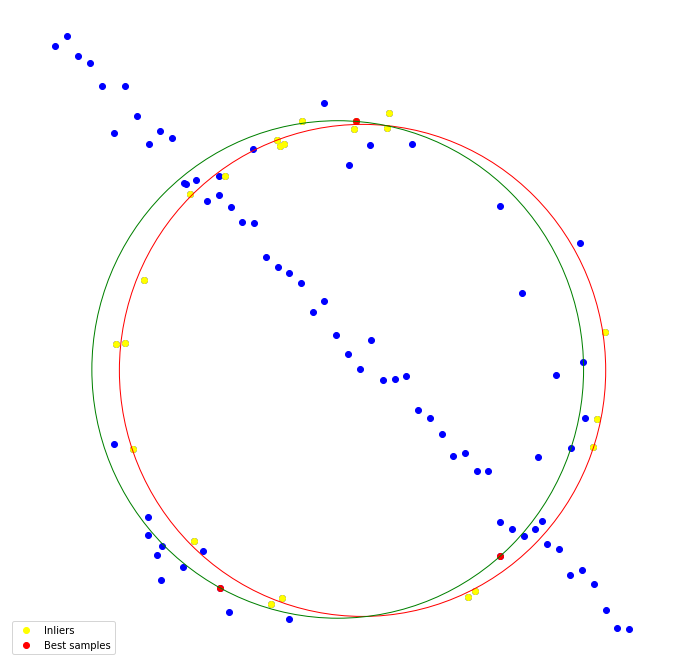

In [20]:
best_model = RANSAC_Circle(X_circle)
xc,yc,r,_ = cf.least_squares_circle(best_model[2])

figure, ax = plt.subplots(figsize=(12, 12))
RASNSAC_circle = plt.Circle(best_model[0], best_model[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Best sample')    
ax.add_artist(circle)
ax.scatter(X_circle[:, 0], X_circle[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_model[3][:, 0], best_model[3][:, 1], c='yellow', label='Inliers')
ax.scatter(best_model[2][:, 0], best_model[2][:, 1], c='red', label='Best samples')
plt.legend(loc=3)
plt.xlim(-14, 14)
plt.axis('off')
plt.savefig(r"img_1.png")
plt.show()

(b) Show in the same plot, the point set, the circle estimated from the sample leading to the best estimate,
this sample of three points, inliers, and the best-fit circle.

Q2-Figure 2 shows an architectural image1 with a flag 2
superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice

Q3-In this questions, we will stitch the two Graffiti image3
img1.ppm onto img5.ppm.

(a) Compute and match SIFT features between the two images.

(b) Compute the homography using your own code within RANSAC and compare with the homography
given in the dataset.

(c) Stitch img1.ppm onto img5.ppm.